# Exciton in a Cavity: Polaritons 

A [polariton](https://en.wikipedia.org/wiki/Polariton) is a quasi-particle that forms due to the interaction between an optical mode and an exciton. Polaritons are light-matter hybrids that can exhibit a mixture of properties typical of photons and excitons.

Here, we will study the dynamics of an exciton-polariton system given by a monochromatic cavity coupled to a molecule's optical excited state. The molecule also has a dark triplet state that can be populated via [intersystem crossing](https://en.wikipedia.org/wiki/Intersystem_crossing) (ISC).

## Import modules and packages

In [8]:
import numpy as np
import matplotlib.pyplot as plt

## Cavity Hamiltonian

A monochromatic cavity mode is a quantum harmonic oscillator with frequency $\omega_c$:

$H_c = \omega_c \hat{a}^\dagger \hat{a} = \omega_c \hat{n}$,

where $\hat{n}$ is the number operator and $\hat{a}^\dagger$ the creation operator of the cavity.

Construct the cavity Hamiltonian truncating the space of states to a maximum number of excitations $n_\mathrm{max}=3$, and a frequency $\omega_c = 1$.

Then, construct the creation and annihilation operators using the following definition:
\begin{aligned}\hat{a}^{\dagger }|n\rangle &={\sqrt {n+1}}|n+1\rangle \\ \hat{a}|n\rangle &={\sqrt {n}}|n-1\rangle .\end{aligned},
and testing that $\hat{a}^\dagger \hat{a} = \hat{n}$.

In [9]:
# maximum occupation number
nmax = 3

# number operator (counting from 0)
n = np.diag([k for k in range(nmax+1)])

# cavity frequency
wc = 1

# cavity Hamiltonian
Hc = wc*n

# creation operator
a = np.zeros((nmax+1,nmax+1))
for k in range(nmax):
    a[k,k+1]=np.sqrt(k+1)

a.conj().T @ a

array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 3.]])

## Exciton Hamiltonian

The exciton Hamiltonian is composed of the ground ($S_0$), optically excited ($S_1$) and dark excited ($T_1$) states, which have energies $0$, $\varepsilon_S$ and $\varepsilon_T$, respectively:

$ H_e = \varepsilon_S |S_1\rangle\langle S_1| + \varepsilon_T |T_1\rangle\langle T_1|$.

Construct the exciton Hamiltonian for $\varepsilon_S = 1$ and $\varepsilon_T = 0.5 \varepsilon_S$. The construct the exciton creation operators:

- $S^\dagger = |S_1\rangle\langle S_0|$
- $T^\dagger = |T_1\rangle\langle S_0|$

In [10]:
# singlet energy
eS = 1

# triplet energy
eT = 0.5 * eS

# exciton Hamilotnian (assuming order S0,S1,T1)
He = np.diag([0,1,0.5])

# exciton states
S0 = np.array([1,0,0])
S1 = np.array([0,1,0])
T1 = np.array([0,0,1])

# annihilation operators
S = np.outer(S0,S1.conj().T)
T = np.outer(S0,T1.conj().T)

## Exciton-photon coupling and polariton Hamiltonian

The interaction $V$ between the cavity and the atom is described by the atom-field dipolar interaction (Dicke model), which reads:

$V = g (\hat{a}^\dagger + \hat{a})\otimes (S^\dagger + S)$.

This leads to the total Hamiltonian:

$H = H_c\otimes \mathbb{1} + \mathbb{1}\otimes H_e + V$.

However, if the ration between the coupling strength $g$ and the cavity frequency $\omega_c$ is small, $g/\omega_c \ll 1$, we can perform the rotating wave approximation (RWA), and replace $V$ with the following interaction:

$V \to V_\mathrm{RWA} = g (\hat{a}\otimes S^\dagger + \hat{a}^\dagger\otimes S)$

Construct the total Hamiltonian for $g=0.001$, testing if the RWA is respected by checking that $g/\omega_c < 0.01$.

In [11]:
# function to get the total Hamiltonian
def Hamiltonian(wc=1, eS=1, eT=1, g=0, nmax = 3, RWA_test = 0.01, printing=True):
    
    # number operator (counting from 0)
    n = np.diag([k for k in range(nmax+1)])
    
    # cavity Hamiltonian
    Hc = wc*n
    
    # creation operator
    a = np.zeros((nmax+1,nmax+1))
    for k in range(nmax):
        a[k,k+1]=np.sqrt(k+1)

    # exciton Hamilotnian (assuming order S0,S1,T1)
    He = np.diag([0,1,0.5])
    
    # exciton states
    S0 = np.array([1,0,0])
    S1 = np.array([0,1,0])
    T1 = np.array([0,0,1])
    
    # annihilation operators
    S = np.outer(S0,S1.conj().T)
    T = np.outer(S0,T1.conj().T)

    # RWA test
    RWA = (g/wc < RWA_test)
    if printing:
        print('RWA is',RWA)

    if RWA is True:
        V = g*(np.kron(a,S.conj().T) + np.kron(a.conj().T,S) )
    else:
        V = g*np.kron(a.conj().T+a,S.conj().T+S)

    H = np.kron(Hc,np.eye(len(He))) + np.kron(np.eye(len(Hc)),He) + V
    
    return H

# coupling strength
g = 0.001

# construct Hamiltonian
H = Hamiltonian(wc=wc,eS=eS,eT=eT,g=g,nmax=4)

RWA is True


## Polariton dispersion relation and hybrid character

Let us consider a cavity with the following dispersion relation:
$\omega_c(\theta) =  \frac{\omega_0 }{\sqrt{1 - \sin^2(t)}}$.

Calculate the eigenvalues $\varepsilon_k$ of the total Hamiltonian $H$ as a function of $\theta$ for $\omega_0=0.8$, choosing $n_\mathrm{max} = 1$ and $g = 0.1$. Compare them to the eigenvalues of the non-interacting ($g=0$) system Hamiltonian $H_0 = H|_{g=0}$.

To calculate and sort the eigenvectors you can use `eigensorter` from `tools`.

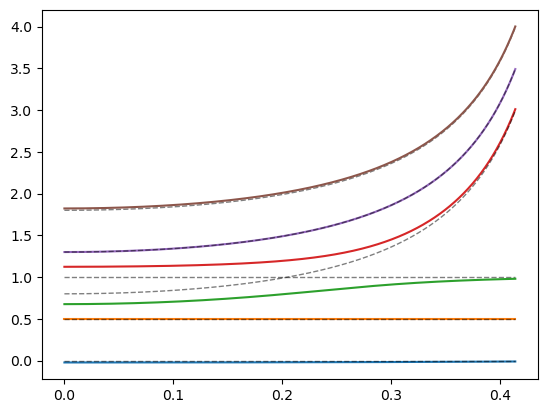

In [12]:
# import eigensorter
from tools import eigensorter

# dispersion relation of the cavity
energy_cavity = lambda th, w0 = 1: w0*(1-np.sin(th)**2)**(-1/2)

# angles
ths = np.linspace(0,1.3,1000)

# max occupation
nmax = 1

# interaction strength
g = 0.2

# cavity base frequency
w0 = 0.8

# eigenvalues datasets
data = []
data0 = []

# loop over angles
for th in ths:
    # cavity energy
    wc = energy_cavity(th,w0=w0)
    # construct Hamilotnian
    H = Hamiltonian(wc=wc,eS=eS,eT=eT,g=g, nmax = nmax, printing = False)
    # calculate the eigenvalues
    evals, ekets = eigensorter(H)
    data.append(evals)
    # construct non-interacting Hamilotnian
    H0 = Hamiltonian(wc=wc,eS=eS,eT=eT,g=0, nmax = nmax, printing = False)
    # calculate the eigenvalues
    evals, _ = np.linalg.eig(H0)
    data0.append(evals)

# organise data
data = np.array(data).T
data0 = np.array(data0).T

# figure
fig, ax = plt.subplots()

for k in range(len(data)):
    ax.plot(ths/np.pi,data[k])
    ax.plot(ths/np.pi,data0[k],'k--', lw = 1, alpha = 0.5)

## Single excitation manifold

The single excitation manifold is composed of the states that contain at most one excitation:

- 1-photon state: $|\text{photon}\rangle = |1\rangle\otimes|S_0\rangle$
- 1-singlet state: $|\text{singlet}\rangle =|0\rangle\otimes|S_1\rangle$
- 1-triplet state: $|\text{triplet}\rangle =|0\rangle\otimes|T_1\rangle$

where $|n\rangle$ is the cavity state with $n$ photons.

Construct the single excitation manifold states and write a function to measure their population $p_\phi$ for any considered state $\rho$, i.e.,

- $p_\phi = \mathrm{Tr}[\rho |\phi\rangle\langle\phi|]$

Then, use this function to study the hybridisation of the eigenstates of the Hamiltonian as a function of the $\theta$.

**Note**: Choose $n_\mathrm{max} = 1$ to simplify calculations.

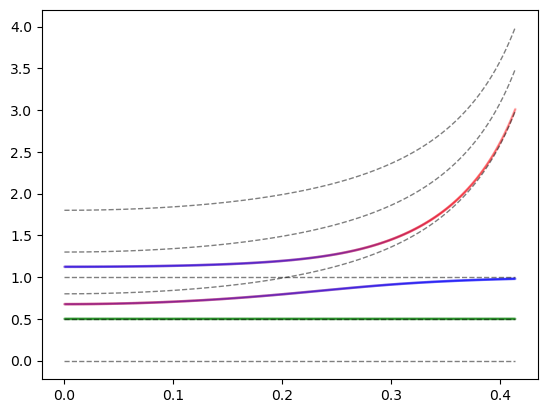

In [13]:
# nmax
nmax = 1

# new annihilation operator
a = np.zeros((nmax+1,nmax+1))
for k in range(nmax):
    a[k,k+1]=np.sqrt(k+1)

# Cavity Hamiltonian
Hc = wc*a.conj().T @a
evals,ekets = eigensorter(Hc)
n0 = ekets[0]
n1 = ekets[1]

# single excitation states
triplet = np.kron(n0, T1)
singlet = np.kron(n0, S1)
photon = np.kron(n1, S0)

# character
def character(rho, character = triplet):
    # character operator
    O = np.outer(character,character.conj().T)
    # measure population of character
    pop = np.trace(O @ rho)
    # return
    return pop

# results 
data = []
chars = []

# loop over angles
for th in ths:
    # cavity energy
    wc = energy_cavity(th,w0=w0)
    # construct Hamilotnian
    H = Hamiltonian(wc=wc,eS=eS,eT=eT,g=g, nmax = nmax, RWA_test = 1, printing = False)
    # calculate the eigenvalues
    evals, ekets = eigensorter(H)
    data.append(evals)
    # measure character
    p1 = [character(np.outer(ket,ket.conj().T),photon) for ket in ekets] 
    s1 = [character(np.outer(ket,ket.conj().T),singlet) for ket in ekets] 
    t1 = [character(np.outer(ket,ket.conj().T),triplet) for ket in ekets] 
    # append characters
    chars.append([p1,s1,t1])

# organise data
data = np.array(data).T
chars = np.array(chars).T

# figure
fig, ax = plt.subplots()

for k in range(len(data)):
    # plot cavity (red)
    ax.scatter(ths/np.pi, data[k], c = 'r', s = 1, alpha = 0.2*chars[k][0])
    # plot singlet character (blue)
    ax.scatter(ths/np.pi, data[k], c = 'b', s = 1, alpha = 0.2*chars[k][1])
    # plot triplets character (green)
    ax.scatter(ths/np.pi, data[k], c = 'g', s = 1, alpha = 0.2*chars[k][2])
    # plot non-interacting eigenvalues
    ax.plot(ths/np.pi,data0[k],'k--', lw = 1, alpha = 0.5)

## Dynamics

We now consider a laser pumping the system with a frequency in resonance with the cavity $\omega_p = \omega_c$ and study the evolution of the polariton generated by the total Hamiltonian $H_\mathrm{tot} = H + H_p$ where $H_p$ is the laser pump Hamiltonian, and the Lindblad operators associated with incoherent transitions:

1. Total Hamiltonian in the rotating frame with frequency $\omega_p$ and amplitude $J$:
    - $H_\mathrm{tot} = H + H_p$
    - $H_p= \sum_k \bigg[ J\Big(|\varphi_k\rangle\langle \text{vac}| + h.c.\Big) -\omega_p |\varphi_k\rangle\langle \varphi_k| \bigg]$,
  
where $|\varphi_k\rangle = \{ |1\rangle\otimes|S_0\rangle, |0\rangle\otimes|S_1\rangle, |1\rangle\otimes|S_1\rangle \}$ are the *bright* states that couple with the laser pump field, and $|\text{va}\rangle = |0\rangle\otimes|S_0\rangle$ is the vacuum state.
      
2. Lindblad operators for:
    - Cavity loss (photon emission) $\sqrt{\gamma_c}\:a\otimes\mathbb{1}$
    - Singlet radiative emission $\sqrt{\gamma_S}\: \mathbb{1}\otimes S$
    - Triplet recombination $\sqrt{\gamma_T} \: \mathbb{1}\otimes  T$
    - Intersystem crossing $\sqrt{\gamma_{ISC}}\:\mathbb{1}\otimes  T^\dagger S$
  
Use the following parameters:

- $\psi_0 = |\text{vac}\rangle  = |0\rangle\otimes|S_0\rangle $
- $J = 1$
- $w_c = 0.8$
- $w_p = w_c$
- $g = 0.1$
- $n_\mathrm{max} = 1$ 
- $\varepsilon_S =1$
- $\varepsilon_T =0.5$
- $\gamma_c = 0.1$
- $\gamma_s = 0.1$
- $\gamma_t = 0.001$
- $\gamma_\mathrm{ISC} = 0.01$

RWA is False


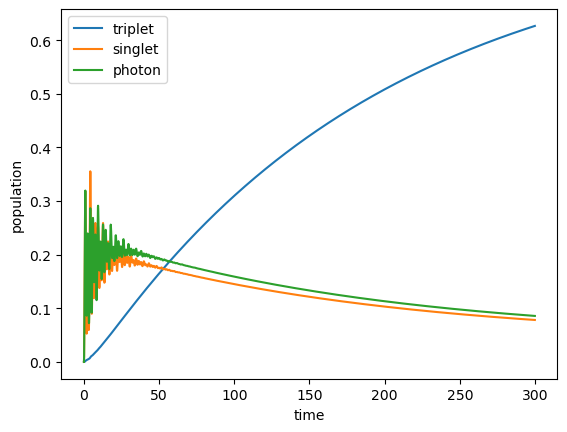

In [14]:
# pump amplitude
J = 1

# cavity frequency
wc = 0.8

# exciton energies
eS,eT = 1,0.5

# pump frequency
wp = wc

# coupling
g = 0.1

# max occupation number
nmax = 1

# Coherent pumping

# Hamiltonian
H = Hamiltonian(wc=wc,eS=eS,eT=eT,g=g,nmax=nmax,RWA_test=0)

# egienstates
evals, ekets = eigensorter(H)

# vacuum state
vac = np.kron(n0,S0)

# select the bright states
bright_states = [ np.kron(n0,S1), np.kron(n1,S0), np.kron(n1,S1) ]

# pumping Hamiltonian
Hp = (sum([-wp*np.outer(eket,eket.conj().T) for eket in bright_states])
      +sum([J*(np.outer(vac,eket.conj().T)
               +np.outer(eket,vac.conj().T)) for eket in bright_states])
     )

# total hamiltonian
Htot = H + Hp

# Decoherence

# rates
gc = 0.1
gs = 0.1
gt = 0.001
gISC = 0.01

# Lindblad operators
c_ops = [np.sqrt(gc)*np.kron(a,np.eye(len(He))),
         np.sqrt(gs)*np.kron(np.eye(len(a)),S),
         np.sqrt(gt)*np.kron(np.eye(len(a)),T),
         np.sqrt(gISC)*np.kron(np.eye(len(a)),T.conj().T@S)
        ]

# function to get the Liouville superoperator
def liouvillian(H, c_ops = []):
    d = len(H) # dimension of the system
    superH = -1j * ( np.kron(np.eye(d),H)-np.kron(H.T,np.eye(d)) ) # Hamiltonian part
    superL = sum([np.kron(L.conjugate(),L) 
                  - 1/2 * ( np.kron(np.eye(d),L.conjugate().T.dot(L)) +
                            np.kron(L.T.dot(L.conjugate()),np.eye(d)) 
                          ) for L in c_ops])
    return superH + superL

# propagation 
def prop(P,rho):
    # get system dimension
    dim = rho.shape[0]
    # propagate vectorise rho
    v = P @ np.reshape(rho,(dim*dim,1))
    # return density operator
    return np.reshape(v,(dim,dim))

# superoperator
super = liouvillian(Htot,c_ops)

# import matrix exponential
from scipy.linalg import expm

# final time
tf = 300

# time interval
dt = 0.1

# times
times = np.arange(0,tf,dt)

# propagator
Pdt = expm(super*dt)

# initial state
psi0 = vac
rho0 = np.outer(psi0,psi0.conj().T)
rho = rho0

# datasets
pT = []
pS = []
pP = []

# propagate
for t in times:
    # append measurement
    pT.append( character(rho,triplet) )
    pS.append( character(rho,singlet) )
    pP.append( character(rho,photon) )

    # new state
    rho = prop(Pdt,rho)

fig, ax = plt.subplots()
ax.plot(times, pT, label = 'triplet');
ax.plot(times, pS, label = 'singlet');
ax.plot(times, pP, label = 'photon');
ax.set_xlabel('time');
ax.set_ylabel('population');
ax.legend();